<a href="https://colab.research.google.com/github/Maria-Djadi01/Sentiment-analysis-of-OMC-feedbacks/blob/main/Notebooks/Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# init

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.5 MB/s eta 0:00:0

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Projects/Incubathon Project'

In [4]:
!ls "$path"

classification_model  Data  DVC  model	Presentation


In [5]:
!cp -r "$path/Data" data

In [6]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, DataCollatorWithPadding
from datasets import Dataset, load_dataset, DatasetDict

# Read Data

In [7]:
dz_df = pd.read_csv(os.path.join("data", "DZMedicaldata.csv"))
dz_df

,ID,Question,Answer
0,2,وش هوما المأكولات لي يديرو الاسهال؟,الحليب و مشتقات الحليب
1,3,وش هوما المأكولات لي يديرو الصداع؟,القهوة . مشتقات الهيستامين\r\n
2,4,وشنهي هو فقر الدم؟,نقص كريات الدم الحمراء او الحديد\r\n
3,5,كيفاش تفيدني أشعة الشمس؟,فيتامين د\r\n
4,6,شحال الوزن الطبيعي نتاع انسان بالغ؟,مؤشر الكتلة الطبيعية بين ثمانية واحد و خمسة اثنين
...,...,...,...
2145,2147,وش لي يقدر يتسبب بيه ثاني,الجنس و العمر
2146,2148,وش لي يقدر يتسبب بيه ثاني,الوراثة و الأصول العرقية
2147,2149,وش يقدر يدير ووش هي مضاعفاتو,التهاب المسالك البولية
2148,2150,وش يقدر يدير ووش هي مضاعفاتو,هشاشة العظام


In [8]:
algerian_reviews_df = pd.read_csv(os.path.join("data", "AlgerianReview.csv"))
algerian_reviews_df

,name,date,likes,comment,sentiment,source
0,djezzy.dz,04/03/20 10:29:29,2309,استفيدوا من عروض جازي عايلة الجديدة لي توالم ك...,0,insta
1,amira_la_bonoise,04/03/20 10:31:18,0,Conx ta3koum dayra ki lhaaaam w say,-1,insta
2,noureddiiiiiine,04/03/20 10:31:38,0,@zaki_medjber_62,0,insta
3,linaragguem,04/03/20 10:32:28,0,ما فهمتش هي sim وحدة يخدمو بها العائلة كاملة,0,insta
4,samo_oussama,04/03/20 10:36:29,0,🙏😉🙏,1,insta
...,...,...,...,...,...,...
5315,alaa_aladin,09/03/19 10:48:28,0,😋😋😋,1,insta
5316,dima.dima.dz,10/03/19 18:29:27,0,Djezzy DIMA KAYEN J`DID,1,insta
5317,_aus_____,20/03/19 17:27:04,0,Votre connexion Internet c'est de la merde !!!,-1,insta
5318,rah_imou_off,24/03/19 11:39:55,0,شوف ستوري,0,insta


In [9]:
arabic_df = pd.read_csv(os.path.join("data", "ar_reviews_100k.tsv"), sep='\t')
arabic_df

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [10]:
french_english_df = pd.read_csv(os.path.join("data", "eng_-french.csv"))
french_english_df

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


#Preprocess Phase

In [11]:
algerian_reviews_df = algerian_reviews_df.drop(columns=["name", "date", "likes", "source", "sentiment"], inplace=False)
algerian_reviews_df

,comment
0,استفيدوا من عروض جازي عايلة الجديدة لي توالم ك...
1,Conx ta3koum dayra ki lhaaaam w say
2,@zaki_medjber_62
3,ما فهمتش هي sim وحدة يخدمو بها العائلة كاملة
4,🙏😉🙏
...,...
5315,😋😋😋
5316,Djezzy DIMA KAYEN J`DID
5317,Votre connexion Internet c'est de la merde !!!
5318,شوف ستوري


In [12]:
def clean_text(text):
  
    #remove usernames
    text = re.sub(r'@[^\s]+', r"", text)
    #remove special characters 
    text = re.sub(r"[^a-zA-Z 'أ-ي]", r"", text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

In [13]:
algerian_reviews_df['comment'] = algerian_reviews_df['comment'].apply(clean_text)

algerian_reviews_df.head(10)

,comment
0,استفيدوا من عروض جازي عايلة الجديدة لي توالم ك...
1,Conx takoum dayra ki lhaaaam w say
2,
3,ما فهمتش هي sim وحدة يخدمو بها العائلة كاملة
4,
5,connection khraaaaa welat
6,DA trimestre
7,Barkawna bla orti cnx takom dayra kilera
8,Le Prix combien
9,Ppppf yaw diro Go b da kan bghito je suis vrai...


In [14]:
algerian_reviews_df.drop(algerian_reviews_df[algerian_reviews_df['comment'] == ''].index, inplace=True)
algerian_reviews_df

,comment
0,استفيدوا من عروض جازي عايلة الجديدة لي توالم ك...
1,Conx takoum dayra ki lhaaaam w say
3,ما فهمتش هي sim وحدة يخدمو بها العائلة كاملة
5,connection khraaaaa welat
6,DA trimestre
...,...
5314,Slvp nedet nebdl ma puce tai men hayela bezzaf...
5316,Djezzy DIMA KAYEN JDID
5317,Votre connexion Internet c'est de la merde
5318,شوف ستوري


In [15]:
algerian_reviews_df.duplicated().sum()

522

In [16]:
algerian_reviews_df.drop_duplicates(inplace=True)

In [17]:
algerian_reviews_df.isna().sum()

comment    0
dtype: int64

In [18]:
algerian_reviews_df["Language"] = 1
daridja_df = algerian_reviews_df.rename(columns={"comment" : "Text"})
daridja_df

,Text,Language
0,استفيدوا من عروض جازي عايلة الجديدة لي توالم ك...,1
1,Conx takoum dayra ki lhaaaam w say,1
3,ما فهمتش هي sim وحدة يخدمو بها العائلة كاملة,1
5,connection khraaaaa welat,1
6,DA trimestre,1
...,...,...
5314,Slvp nedet nebdl ma puce tai men hayela bezzaf...,1
5316,Djezzy DIMA KAYEN JDID,1
5317,Votre connexion Internet c'est de la merde,1
5318,شوف ستوري,1


# DZ Dataset

In [19]:
dz_df

,ID,Question,Answer
0,2,وش هوما المأكولات لي يديرو الاسهال؟,الحليب و مشتقات الحليب
1,3,وش هوما المأكولات لي يديرو الصداع؟,القهوة . مشتقات الهيستامين\r\n
2,4,وشنهي هو فقر الدم؟,نقص كريات الدم الحمراء او الحديد\r\n
3,5,كيفاش تفيدني أشعة الشمس؟,فيتامين د\r\n
4,6,شحال الوزن الطبيعي نتاع انسان بالغ؟,مؤشر الكتلة الطبيعية بين ثمانية واحد و خمسة اثنين
...,...,...,...
2145,2147,وش لي يقدر يتسبب بيه ثاني,الجنس و العمر
2146,2148,وش لي يقدر يتسبب بيه ثاني,الوراثة و الأصول العرقية
2147,2149,وش يقدر يدير ووش هي مضاعفاتو,التهاب المسالك البولية
2148,2150,وش يقدر يدير ووش هي مضاعفاتو,هشاشة العظام


In [20]:
dz_df = dz_df.drop(columns=["Answer", "ID"], inplace=False)
dz_df

,Question
0,وش هوما المأكولات لي يديرو الاسهال؟
1,وش هوما المأكولات لي يديرو الصداع؟
2,وشنهي هو فقر الدم؟
3,كيفاش تفيدني أشعة الشمس؟
4,شحال الوزن الطبيعي نتاع انسان بالغ؟
...,...
2145,وش لي يقدر يتسبب بيه ثاني
2146,وش لي يقدر يتسبب بيه ثاني
2147,وش يقدر يدير ووش هي مضاعفاتو
2148,وش يقدر يدير ووش هي مضاعفاتو


In [21]:
dz_df['Question'] = dz_df['Question'].apply(clean_text)

dz_df.head(10)

,Question
0,وش هوما المأكولات لي يديرو الاسهال
1,وش هوما المأكولات لي يديرو الصداع
2,وشنهي هو فقر الدم
3,كيفاش تفيدني أشعة الشمس
4,شحال الوزن الطبيعي نتاع انسان بالغ
5,وشنهي هي الماكلة لي تقدر تفيدني بفيتامين د
6,وش هي الأخطار نتاع الكحول على الجسم نتاعنا
7,وين جاية الغدة الدرقية في الجسم
8,شحال نحتاج نشرب الما يوميا
9,شحال درجة الحرارة الطبيعية نتاعنا


In [22]:
dz_df.duplicated().sum()

980

In [23]:
dz_df.drop_duplicates(inplace=True)

In [24]:
dz_df.isna().sum()

Question    0
dtype: int64

In [25]:
dz_df["Language"] = 1
dz_df = dz_df.rename(columns={"Question" : "Text"})
dz_df

,Text,Language
0,وش هوما المأكولات لي يديرو الاسهال,1
1,وش هوما المأكولات لي يديرو الصداع,1
2,وشنهي هو فقر الدم,1
3,كيفاش تفيدني أشعة الشمس,1
4,شحال الوزن الطبيعي نتاع انسان بالغ,1
...,...,...
2124,كيفاه نحمي روحي من صفاير,1
2127,وش هو التهاب القنوات الصفراوية الأولي,1
2140,وش هو اسبابو,1
2145,وش لي يقدر يتسبب بيه ثاني,1


In [26]:
daridja_df = dz_df.append(daridja_df)

In [27]:
max = len(daridja_df) / (0.5)

## Arabic Dataset

In [28]:
arabic_df = arabic_df.drop(columns=["label"])

In [29]:
arabic_df

,text
0,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...
99994,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [30]:
arabic_df = arabic_df.rename(columns={"text" : "Text"})
arabic_df

,Text
0,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...
99994,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [31]:
arabic_df['Text'] = arabic_df['Text'].apply(clean_text)

arabic_df.head(10)

,Text
0,ممتاز نوعا ما النظافة والموقع والتجهيز والشاطي...
1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,هادفة وقوية تنقلك من صخب شوارع القاهرة الى هدو...
3,خلصنا مبدئيا اللي مستني ابهار زي الفيل الازرق ...
4,ياسات جلوريا جز لا يتجزأ من دبي فندق متكامل ال...
5,أسلوب الكاتب رائع جدا و عميق جدا قرأته عدة مرا...
6,استثنائي الهدو في الجناح مع مسبح عدم وجود عازل...
7,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,من أجمل ما قرأت رواية تستحق القراة فعلا
9,بشكل عام جيده التجاوب جيد جدا من قبل موظفي الا...


In [32]:
arabic_df.duplicated().sum()

80

In [33]:
arabic_df = arabic_df.sample(int(0.15 * max))

In [34]:
arabic_df.isna().sum()

Text    0
dtype: int64

In [35]:
arabic_df["Language"] = 0

In [36]:
arabic_df.head()

,Text,Language
86541,موضوع الكتاب مثير لكن اسلوبه مملممل حتى بالنسب...,0
31451,اقامة ممتازة الموقع ممتازوالاستقبالعمالة التحم...,0
84529,تجنب حفرة الجحيم هذه عندما توجهت أنا وزملائي إ...,0
32045,فندق رائع الفندق متميز كغرف و اثاث و اطلاله و ...,0
43032,حسن الاستقبال خدمات الغرف,0


## French Dataset

In [37]:
french_df = french_english_df.drop(columns=["English words/sentences"], inplace=False)

In [38]:
french_df = french_df.rename(columns={"French words/sentences":"Text"})

In [39]:
french_df['Text'] = french_df['Text'].apply(clean_text)

In [40]:
french_df.duplicated().sum()

10539

In [41]:
french_df.drop_duplicates(inplace=True)

In [42]:
french_df.isna().sum()

Text    0
dtype: int64

In [43]:
french_df = french_df.sample(int(0.20 * max))

In [44]:
french_df["Language"] = 0

## English Dataset

In [45]:
english_df = french_english_df.drop(columns=["French words/sentences"], inplace=False)

In [46]:
english_df = english_df.rename(columns={"English words/sentences":"Text"})

In [47]:
english_df['Text'] = english_df['Text'].apply(clean_text)

In [48]:
english_df.duplicated().sum()

52675

In [49]:
english_df.drop_duplicates(inplace=True)

In [50]:
english_df.isna().sum()

Text    0
dtype: int64

In [51]:
english_df = english_df.sample(int(0.15 * max))

In [52]:
english_df["Language"] = 0

In [53]:
english_df

,Text,Language
22090,You can't come in,0
142096,The doctor arrived in the nick of time,0
20032,It's hot out here,0
175551,Since I've been on this diet my weight is down...,0
151561,He can't say anything to his father's face,0
...,...,...
42830,It's all so senseless,0
149450,His family emigrated to the United States,0
59256,Are you losing your mind,0
173967,Many people think that children don't spend en...,0


## Creation of final dataframe

In [54]:
not_daridja_df = french_df.append(english_df.append(arabic_df))

In [55]:
final_df = not_daridja_df.append(daridja_df)

In [56]:
final_df.columns = ["text", "labels"]

In [57]:
final_df = final_df.reset_index(drop=True)
final_df

,text,labels
0,Je ne tolre pas les imbciles,0
1,Je suis reconnaissant pour ce que tu as fait hier,0
2,Il se peut qu'il faille que je parte,0
3,Je ne veux tout simplement pas qu'il y ait une...,0
4,Vous devriez toujours dire la vrit,0
...,...,...
10995,Slvp nedet nebdl ma puce tai men hayela bezzaf...,1
10996,Djezzy DIMA KAYEN JDID,1
10997,Votre connexion Internet c'est de la merde,1
10998,شوف ستوري,1


# Dataset creation

In [58]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(final_df, test_size=0.3)
df_eval, df_test = train_test_split(df_temp, test_size=0.5)

In [59]:
train_dataset = Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_eval)
test_dataset = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    "train": train_dataset,
    "valid": eval_dataset,
    "test": test_dataset,
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7700
    })
    valid: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1650
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1650
    })
})

# Training


In [60]:
model_name = "alger-ia/dziribert"

In [61]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [62]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [63]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(torch_device)

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are

In [64]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### tokenization

In [65]:
def tokenize_function(data):
    return tokenizer(data["text"], padding=True, truncation=True)

In [66]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/7700 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

In [67]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7700
    })
    valid: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1650
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1650
    })
})

### metrics

In [68]:
import evaluate

precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [69]:
def compute_metrics(pred):

    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)

    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {**precision, **recall, **f1, **accuracy,}

### training

In [70]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=50,
    save_steps=50,
    save_total_limit=5,
    warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    load_best_model_at_end = True,
    )

In [71]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5)
    ]
)

In [72]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7700
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 482
  Number of trainable parameters = 124442882
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.543215,0.833721,0.823030,0.821355,0.823030
100,No log,0.204244,0.943592,0.943030,0.942999,0.943030
150,No log,0.133220,0.963218,0.963030,0.963022,0.963030
200,No log,0.118158,0.966153,0.966061,0.966056,0.966061
250,No log,0.105599,0.970873,0.970303,0.970288,0.970303
300,No log,0.086317,0.974939,0.974545,0.974536,0.974545
350,No log,0.116837,0.969857,0.969091,0.969086,0.969091
400,No log,0.088851,0.975942,0.975758,0.975758,0.975758
450,No log,0.105243,0.974677,0.974545,0.974541,0.974545


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1650
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-50/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-50/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Ru

TrainOutput(global_step=482, training_loss=0.19695107867608921, metrics={'train_runtime': 1199.5462, 'train_samples_per_second': 6.419, 'train_steps_per_second': 0.402, 'total_flos': 2025955126272000.0, 'train_loss': 0.19695107867608921, 'epoch': 1.0})

In [73]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1650
  Batch size = 32


{'eval_loss': 0.0863170474767685,
 'eval_precision': 0.9749387456167309,
 'eval_recall': 0.9745454545454545,
 'eval_f1': 0.9745355742412236,
 'eval_accuracy': 0.9745454545454545,
 'eval_runtime': 53.1561,
 'eval_samples_per_second': 31.041,
 'eval_steps_per_second': 0.978,
 'epoch': 1.0}

# Evaluations

In [74]:
trainer.evaluate(tokenized_datasets["test"])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1650
  Batch size = 32


{'eval_loss': 0.09946645796298981,
 'eval_precision': 0.9745353509366887,
 'eval_recall': 0.973939393939394,
 'eval_f1': 0.9739363402377113,
 'eval_accuracy': 0.973939393939394,
 'eval_runtime': 45.7066,
 'eval_samples_per_second': 36.1,
 'eval_steps_per_second': 1.138,
 'epoch': 1.0}

In [75]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix

# Get the predictions for the test dataset
preds = trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=-1)

# Get the true labels for the test dataset
labels = tokenized_datasets["test"]["labels"]

# Compute the confusion matrix
confusion_mat = confusion_matrix(labels, preds)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1650
  Batch size = 32


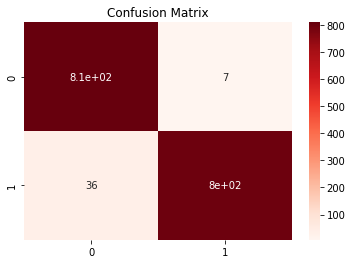

In [76]:
# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(confusion_mat, annot=True, cmap="Reds")

# Add labels and title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [77]:
output_model_file = '/content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model'
trainer.save_model(output_model_file)

Saving model checkpoint to /content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model
Configuration saved in /content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model/config.json
Model weights saved in /content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab Projects/Incubathon Project/classification_model/special_tokens_map.json
